In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Set the base directory for the dataset
base_dir = '/kaggle/input/cv-project-detector/Classifier Data'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize([0.5], [0.5])  # Normalize pixel values
])

# Create datasets
train_dataset = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(base_dir, 'val'), transform=transform)

# Create data loaders
batch_size = 64  # Adjust based on your system capabilities
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example of how to iterate over the data loader
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")  # Shape will be [batch_size, channels, height, width]
    print(f"Batch of labels: {labels}")  # Labels associated with the batch

    # Here you would typically pass images and labels to your model
    # Example: outputs = model(images)
    #          loss = loss_function(outputs, labels)
    # This is where you could implement training steps, validation checks, etc.


Batch of images shape: torch.Size([64, 3, 256, 256])
Batch of labels: tensor([0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0])
Batch of images shape: torch.Size([64, 3, 256, 256])
Batch of labels: tensor([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0])
Batch of images shape: torch.Size([64, 3, 256, 256])
Batch of labels: tensor([1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1])
Batch of images shape: torch.Size([64, 3, 256, 256])
Batch of labels: tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels)
        )
    
    def forward(self, x):
        return F.relu(x + self.block(x), inplace=True)

class Encoder(nn.Module):
    def __init__(self, feature_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # Adjusted to accept 3 input channels
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            ResidualBlock(128),  # Adding a residual block for better feature extraction
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            ResidualBlock(256),  # Another residual block
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            ResidualBlock(512),  # Another residual block
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(1024 * 8 * 8, feature_dim),
            nn.Tanh()  # Ensures output is in the range [-1, 1]
        )
        
    def forward(self, x):
        return self.encoder(x)

# Instantiate the Encoder for RGB images
encoder = Encoder(feature_dim=100)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.initial = nn.Linear(latent_dim, 1024 * 8 * 8)
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.final = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)  # Changed to output 3 channels for RGB
        self.activation = nn.Tanh()  # Outputs values in the range [-1, 1], suitable for image data

    def forward(self, z):
        z = self.initial(z)
        z = z.view(-1, 1024, 8, 8)  # Reshape linear output to match the dimensions for transposed convolution
        z = F.relu(self.bn1(self.up1(z)))  # First upsampling to 16 x 16
        z = F.relu(self.bn2(self.up2(z)))  # Upsampling to 32 x 32
        z = F.relu(self.bn3(self.up3(z)))  # Upsampling to 64 x 64
        z = F.relu(self.bn4(self.up4(z)))  # Upsampling to 128 x 128
        z = self.activation(self.final(z))  # Final upsampling to 256 x 256 and output activation
        return z

# Instantiate the Decoder for RGB images
decoder = Decoder(latent_dim=100)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.PReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.PReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.PReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Outputs a probability
        )
        
    def forward(self, z):
        return self.discriminator(z)

# Instantiate the Discriminator with advanced features
discriminator = Discriminator(latent_dim=100)


In [5]:
# Check if CUDA (GPU support) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print out whether we are on CPU or GPU
print("Using device:", device)


Using device: cuda


In [6]:
# Instantiate models and move them to the device
encoder = Encoder(feature_dim=100).to(device)
decoder = Decoder(latent_dim=100).to(device)
discriminator = Discriminator(latent_dim=100).to(device)

In [7]:
import os
import torchvision.utils as vutils

# Directory to save generated images
image_dir = './generated_images'
os.makedirs(image_dir, exist_ok=True)

In [8]:
import torch.optim as optim
import torchvision.utils as vutils

# Hyperparameters
epochs = 100
lr = 0.0002
latent_dim = 100
real_label = 1
fake_label = 0

# Optimizers
optimizer_G = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss functions
criterion_recon = nn.MSELoss()  # Mean Squared Error Loss for reconstruction
criterion_adv = nn.BCELoss()    # Binary Cross-Entropy Loss for adversarial training

# Training loop
for epoch in range(epochs):
    for data in train_loader:
        images, _ = data
        current_batch_size = images.size(0)  # Get the actual size of the batch
        images = images.to(device)

        # ====================
        # Update Discriminator
        # ====================
        optimizer_D.zero_grad()
        
        # Train with real
        real_latents = torch.randn(current_batch_size, latent_dim, device=device)  # Adjusted to current batch size
        labels_real = torch.full((current_batch_size, 1), real_label, dtype=torch.float, device=device)
        output_real = discriminator(real_latents)
        loss_D_real = criterion_adv(output_real, labels_real)

        # Train with fake
        fake_latents = encoder(images)
        labels_fake = torch.full((current_batch_size, 1), fake_label, dtype=torch.float, device=device)
        output_fake = discriminator(fake_latents.detach())
        loss_D_fake = criterion_adv(output_fake, labels_fake)

        # Combine losses and update
        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # ====================
        # Update Generator (Encoder + Decoder)
        # ====================
        optimizer_G.zero_grad()

        # Adversarial loss (fooling the discriminator)
        output_fake = discriminator(fake_latents)
        loss_G_adv = criterion_adv(output_fake, labels_real)

        # Reconstruction loss
        reconstructed_images = decoder(fake_latents)
        loss_G_recon = criterion_recon(reconstructed_images, images)

        # Combine losses and update
        loss_G = loss_G_adv + loss_G_recon
        loss_G.backward()
        optimizer_G.step()
        
        if (epoch + 1) % 10 == 0:  # Save images every 30 epochs
            with torch.no_grad():
                reconstructed_images = decoder(encoder(images)).detach().cpu()
            vutils.save_image(reconstructed_images, f'{image_dir}/recon_images_epoch_{epoch+1}.png', normalize=True)


    # Logging, checkpointing, etc.
    print(f'Epoch [{epoch+1}/{epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}')


Epoch [1/100] Loss D: 0.6771, Loss G: 0.8084
Epoch [2/100] Loss D: 0.6956, Loss G: 0.7759
Epoch [3/100] Loss D: 0.7207, Loss G: 0.7624
Epoch [4/100] Loss D: 0.6953, Loss G: 0.7877
Epoch [5/100] Loss D: 0.6864, Loss G: 0.7800
Epoch [6/100] Loss D: 0.6972, Loss G: 0.8002
Epoch [7/100] Loss D: 0.6896, Loss G: 0.7616
Epoch [8/100] Loss D: 0.6983, Loss G: 0.7916
Epoch [9/100] Loss D: 0.6964, Loss G: 0.7900
Epoch [10/100] Loss D: 0.6851, Loss G: 0.8380
Epoch [11/100] Loss D: 0.7040, Loss G: 0.7994
Epoch [12/100] Loss D: 0.7069, Loss G: 0.7467
Epoch [13/100] Loss D: 0.6662, Loss G: 0.8638
Epoch [14/100] Loss D: 0.6717, Loss G: 0.8525
Epoch [15/100] Loss D: 0.6998, Loss G: 0.7916
Epoch [16/100] Loss D: 0.6708, Loss G: 0.9548
Epoch [17/100] Loss D: 0.6493, Loss G: 0.8814
Epoch [18/100] Loss D: 0.6484, Loss G: 0.9365
Epoch [19/100] Loss D: 0.6447, Loss G: 1.0443
Epoch [20/100] Loss D: 0.7380, Loss G: 1.1757
Epoch [21/100] Loss D: 0.7156, Loss G: 0.9715
Epoch [22/100] Loss D: 0.6075, Loss G: 1.07

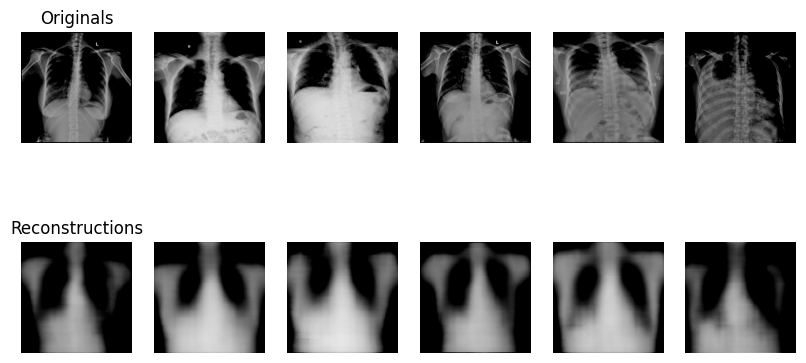

Average MSE on Validation Set: 0.0822


In [9]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def evaluate_model(encoder, decoder, val_loader, device, num_images=6):
    encoder.eval()
    decoder.eval()
    mse_loss = nn.MSELoss()

    total_mse = 0.0
    images_to_show = []

    with torch.no_grad():
        for i, (images, _) in enumerate(val_loader):
            images = images.to(device)
            outputs = decoder(encoder(images))

            # Compute MSE loss
            loss = mse_loss(outputs, images)
            total_mse += loss.item()

            if i == 0:  # Only save images from the first batch
                # Collect original and reconstructed images for display
                images_to_show = (images, outputs)

    avg_mse = total_mse / len(val_loader)

    # Visualize the first `num_images` images and their reconstructions
    fig, axes = plt.subplots(2, num_images, figsize=(10, 5))
    real_images, recon_images = images_to_show
    for idx in range(num_images):
        axes[0, idx].imshow(real_images[idx].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
        axes[0, idx].axis('off')
        axes[1, idx].imshow(recon_images[idx].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
        axes[1, idx].axis('off')
        if idx == 0:
            axes[0, idx].set_title('Originals')
            axes[1, idx].set_title('Reconstructions')

    plt.show()

    return avg_mse

# Evaluate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)
avg_mse_score = evaluate_model(encoder, decoder, val_loader, device)
print(f"Average MSE on Validation Set: {avg_mse_score:.4f}")


In [10]:
# Save the model weights
torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(decoder.state_dict(), 'decoder.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

print("Models saved successfully.")


Models saved successfully.
